In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from face_segmenter import segment_image,rgb2gray
import numpy as np
import skops.io as sio
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

In [2]:
from joblib import load
with open("models/pipe_kmeans64.sio","br") as f:
    obj = f.read()
    unknown_types = sio.get_untrusted_types(data=obj)
    clf = sio.loads(obj,trusted=unknown_types)
    
P_pos_q_cara = np.load("counts/pipe_kmeans64/P_pos_q_cara.npy") + 1
P_q_nocara = np.load("counts/pipe_kmeans64/P_q_nocara.npy") + 1 
P_q_cara = np.load("counts/pipe_kmeans64/P_q_cara.npy") + 1

P_norm_pos_q_cara = P_pos_q_cara / P_pos_q_cara.sum(axis=0)
P_norm_q_cara = P_q_cara / P_q_cara.sum()
P_norm_q_nocara = P_q_nocara / P_q_nocara.sum()

In [3]:
def next_pyramid_step(img,scale = 0.9):
    return cv2.resize(img,None,fy=scale,fx=scale)

In [4]:
def is_cara_region(region:np.ndarray)-> bool:
    q = region.flatten()

    n = len(q)
    r = len(P_norm_q_nocara)
    den = np.prod(P_norm_q_nocara[q]/ (n*r)) 
    num = np.prod(P_norm_pos_q_cara[np.arange(0,n,1,dtype=int),q]) * np.prod(P_norm_q_cara[q])

    res = num / den
    
    return res

In [5]:
def find_caras_in_region(classes_matrix:np.ndarray,square_side = 4,confidence = 3e+33)-> tuple[list[tuple[int,int]],list[int]]:
    """ 
    Encuentra las regiones que son caras y devuelve una 
    lista de los que encuentra, señalando la esquina superior izquierda
    """
    height,width = classes_matrix.shape
    height -= square_side
    width -= square_side
    caras = []
    probs = []
    for i,j in np.ndindex((height + 1,width +1)):
        p_iscara = is_cara_region(classes_matrix[i:i+square_side,j:j+square_side])
        if p_iscara > confidence:
            caras.append((i,j))
            probs.append(p_iscara)
    return caras,probs

In [6]:
def get_real_square(caras:list[tuple[int]],scale_factor:float,padding:tuple[int,int]):
    res = []
    h,w = padding
    for i,j in caras:
        top = round(scale_factor * (h + 8 * i))
        left = round(scale_factor * (w + 8 * j))
        right = round(scale_factor * (w + 8 * (j + 4)))
        bottom = round(scale_factor * (h + 8 * (i + 4)))

        res.append({"top":top,
                    "left":left,
                    "right":right,
                    "bottom":bottom})
    return res

In [7]:
stride = 2
squares = []
square_probs = []
caras_orig = []
for h in range(4):
    for w in range(4):
        mini_patches,shape = segment_image(img,tile_size=8,margin_top=h*stride,margin_left=w*stride)
        mini_patches = mini_patches.reshape(-1,8*8)
        y_pred = clf.predict(mini_patches)
        y_pred = y_pred.reshape(shape[0]//8,shape[1]//8)
        # Recuperar las reguiones con caras y guardar la lista de cuadrados
        caras, probs = find_caras_in_region(y_pred)
        square_probs += probs
        squares += get_real_square(caras,scale_factor=1,padding=(h,w))
        caras_orig += caras
        break
    break


NameError: name 'img' is not defined

In [18]:
img = cv2.imread("images/Screenshot from 2023-05-07 21-06-44.png")
img = rgb2gray(np.array(img))

In [17]:
img.shape

(247, 596)

In [19]:
img_cur = img.copy()
factor_cur = 1
factor = 0.8

stride = 2
squares = []
square_probs = []
caras_orig = []

for i in range(10):
    for h in range(4):
        for w in range(4):
            # Romper la imagen en trozos de 8x8
            mini_patches,shape = segment_image(img_cur,tile_size=8,margin_top=h*stride,margin_left=w*stride)
            mini_patches = mini_patches.reshape(-1,8*8)

            # Predecimos la clase de cado de los trozos
            y_pred = clf.predict(mini_patches)
            y_pred = y_pred.reshape(shape[0]//8,shape[1]//8)
            
            # Recuperar las regiones con caras y guardar la lista de cuadrados
            caras, probs = find_caras_in_region(y_pred,confidence=1e+41)
            square_probs += probs

            # Se calcula el cuadrado en la imagen original dado el factor de escalado y el padding
            new_squares = get_real_square(caras,scale_factor=1/factor_cur,padding=(h,w))
            squares += new_squares
            caras_orig += caras

    # Calcular factores para la siguiente iteración
    factor_cur *= factor
    img_cur = next_pyramid_step(img.copy(),factor_cur)

(396, 573)


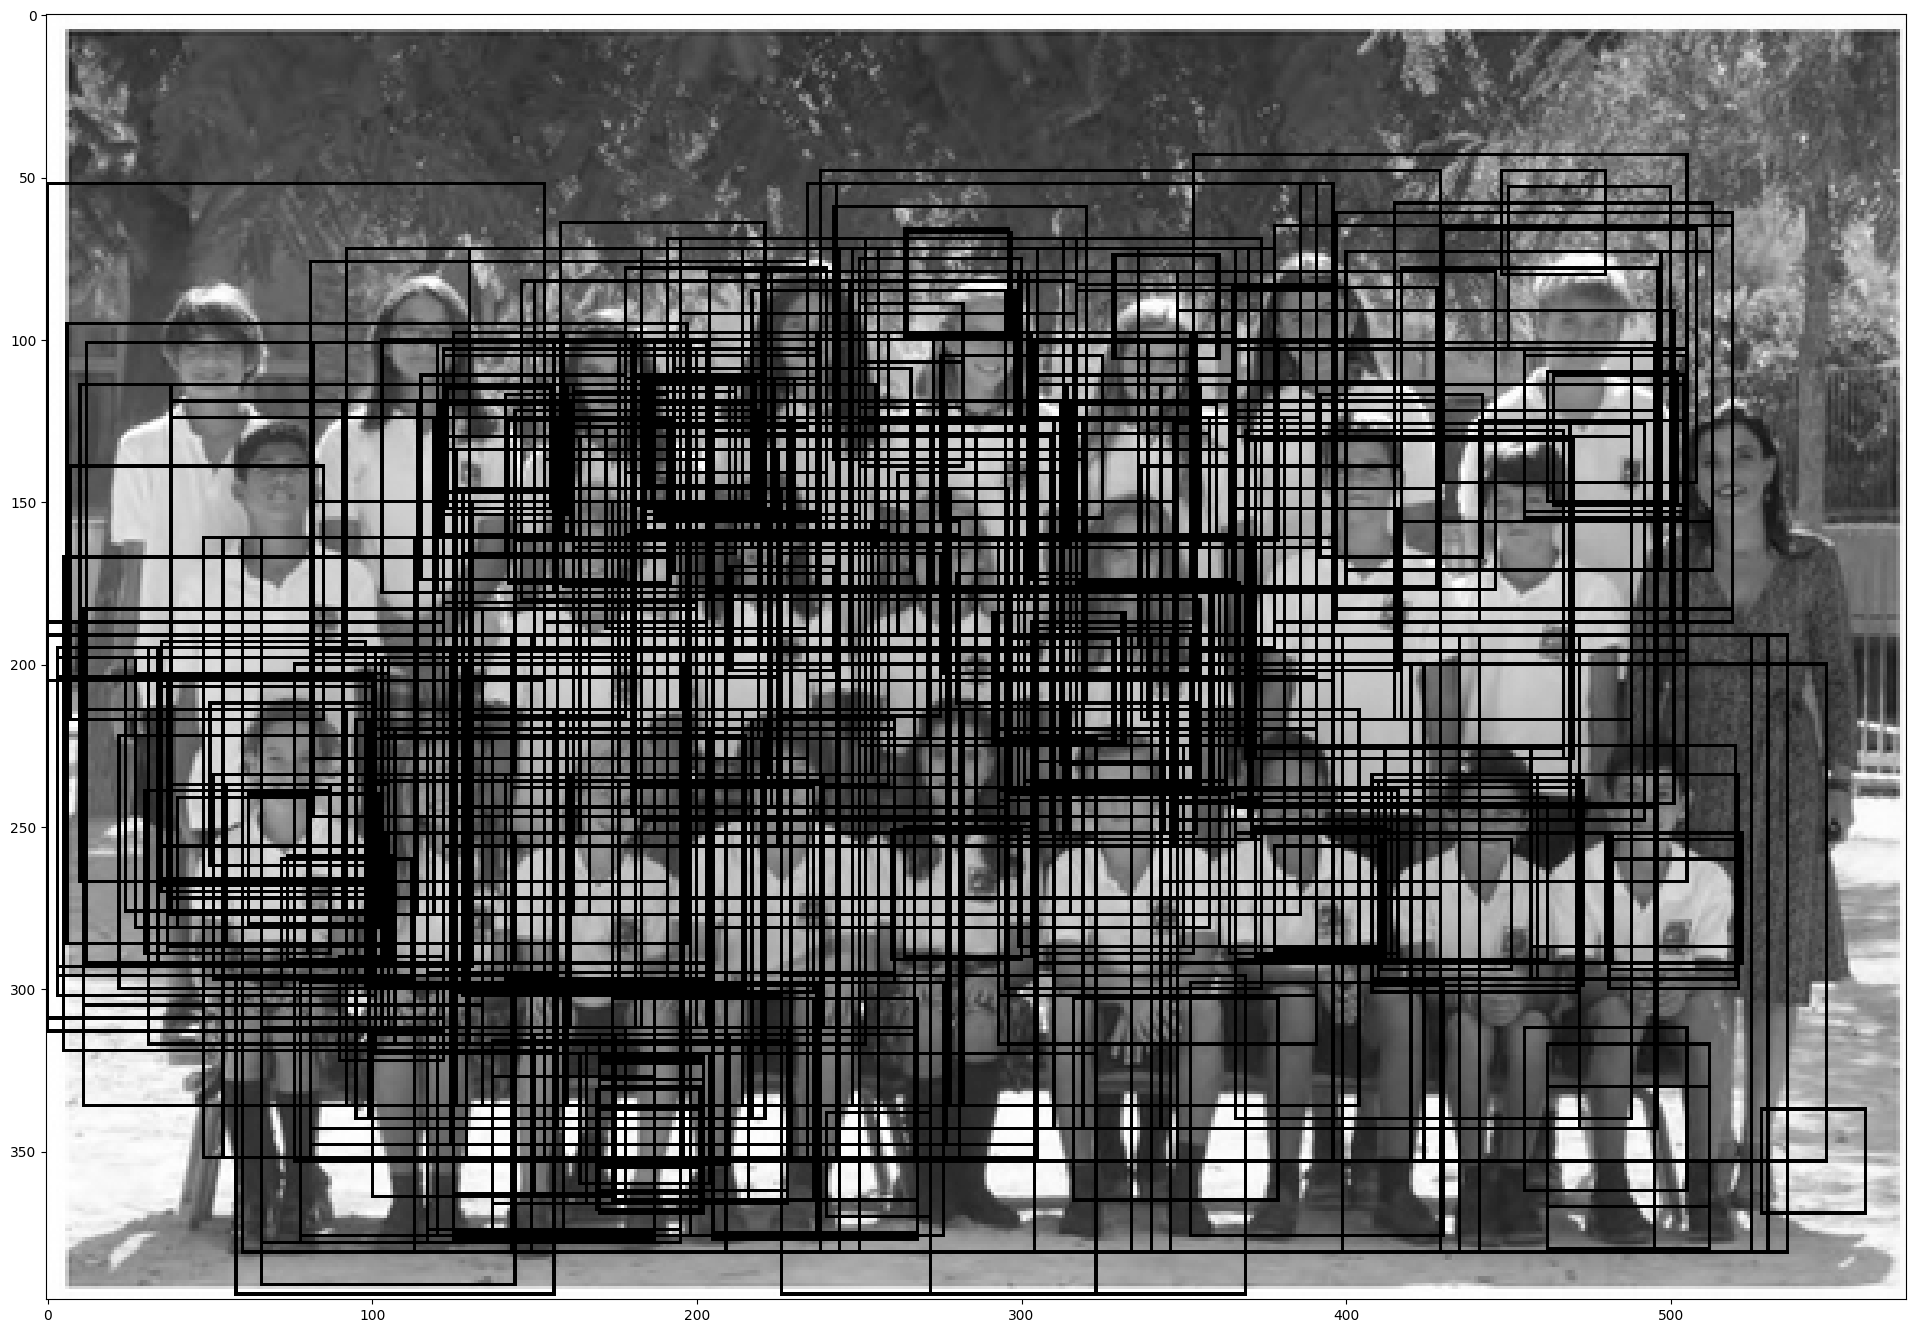

In [20]:
print(img.shape)
fig,(ax1) = plt.subplots(figsize=(24,20))
rect_img = img.copy()
for test_square in squares:
    rect_img = cv2.rectangle(rect_img,(test_square["left"],test_square["top"]),(test_square["right"],test_square["bottom"]),color=(0))
ax1.imshow(rect_img,cmap=plt.get_cmap('gray'))
#plt.axis("off")